In [17]:
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT

In [2]:
def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

In [4]:
test_folder = "./../tensorflow_PSENet/tmp"
image_list, _, _ = file_utils.get_files(test_folder)

In [7]:
result_folder = "./result0616/"
if not os.path.isdir(result_folder):
    os.mkdir(result_folder)

In [8]:
net = CRAFT()     # initialize

In [9]:
if True :
    net = net.cuda()
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = False

In [11]:
 trained_model = "./Pretrained/craft_mlt_25k.pth"
print('Loading weights from checkpoint (' + trained_model+ ')')
net.load_state_dict(torch.load(trained_model))
net.eval()
t = time.time()

Loading weights from checkpoint (./Pretrained/craft_mlt_25k.pth)


In [13]:
check = image_list[0]

In [14]:
image = imgproc.loadImage(check)

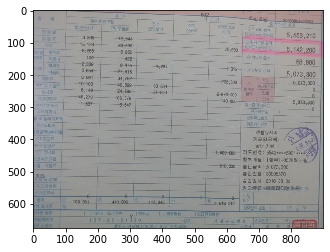

In [18]:
plt.imshow(image)
plt.show()

## test net

In [20]:
mag_ratio = 1.2
canvas_size = 1600
img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, 
                                                                      canvas_size, 
                                                                      interpolation=cv2.INTER_LINEAR, 
                                                                      mag_ratio=mag_ratio)
ratio_h = ratio_w = 1 / target_ratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


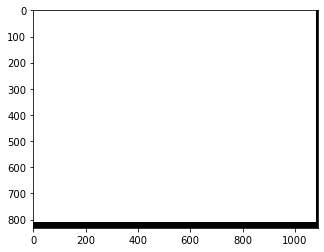

(1.2, (544, 416))

In [25]:
plt.imshow(img_resized)
plt.show()
target_ratio , size_heatmap

In [26]:
x = imgproc.normalizeMeanVariance(img_resized)
x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]

In [28]:
cuda = True
if cuda:
    x = x.cuda()

In [33]:
y, _ = net(x)
print(y.shape)

torch.Size([1, 416, 544, 2])


In [51]:
score_text = y[0,:,:,0].cpu().data.numpy()
score_link = y[0,:,:,1].cpu().data.numpy()

In [69]:
print(np.max(score_link) , np.min(score_link))
print(np.max(score_text) , np.min(score_text))

0.9430612 -0.04829269
1.0298723 0.0008826507


# 여기서 박스가 잘 합쳐지는 부분임! <br>

## 이 부분을 더 파고 들어야함.
## 여기선 확률값


In [52]:
text_threshold = 0.2
link_threshold = 0.1 
low_text = 0.2
boxes = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text)
boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)

In [53]:
boxes.shape

(169, 4, 2)

In [54]:
render_img = score_text.copy()
render_img = np.hstack((render_img, score_link))
ret_score_text = imgproc.cvt2HeatmapImg(render_img)

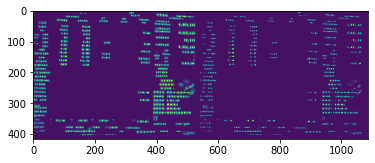

In [55]:
plt.imshow(render_img)
plt.show()

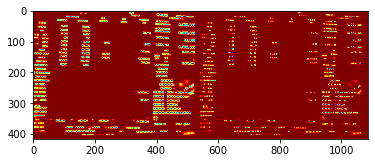

In [56]:
plt.imshow(ret_score_text)
plt.show()

In [47]:
bboxes, score_text = boxes , ret_score_text

In [57]:
type(render_img)

numpy.ndarray

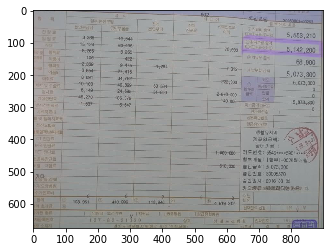

In [61]:
img = np.array(image[:,:,::-1])
plt.imshow(img)
plt.show()

In [63]:
for i, box in enumerate(boxes):
    poly = np.array(box).astype(np.int32).reshape((-1))
    poly = poly.reshape(-1, 2)
    cv2.polylines(img, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)


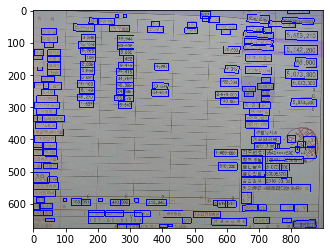

In [64]:
plt.imshow(img)
plt.show()